# Задача биоинформатики

**Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком**
___

**Описание используемых данных**

Данные для этой задачи взяты из исследования, проведенного в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор генов, которые позволили бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человек, у которых не было рака груди (`normal`), 25 человек, у которых это заболевание было диагностировано на ранней стадии (`early neoplasia`), и 23 человека с сильно выраженными симптомами (`cancer`).

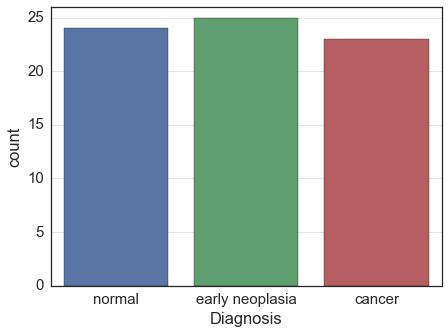

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей.

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

Дан датасет вышеназванной количественной меры активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

Необохдимо определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

**Практическая значимость изменения**

__Цель исследований__ — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется `fold change` (кратность изменения). Определяется она следующим образом:

$$F_C\left(C,\ T\right)=\left\{\begin{matrix}\frac{T}{C},\ \ T>C\\-\frac{C}{T},\ \ T<C\\\end{matrix}\right.$$

где $C$, $T$ — средние значения экспрессии гена в `control` и `treatment` группах соответственно. По сути, `fold change` показывает, во сколько раз отличаются средние двух выборок.

In [1]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

from matplotlib import pyplot

import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("gene_high_throughput_sequencing.csv", header=0) 

In [3]:
data

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,STT5750_Breast_021_DCIS,cancer,1.466240,3.689955,21.331981,19.359546,23.505609,11.576176,11.325851,80.572057,...,2.807635,1.466240,2.807635,1.466240,2.807635,3.689955,18.449777,1.466240,1.466240,1.466240
68,STT5751_Breast_021_IDC,cancer,2.492410,12.279444,30.087759,17.703926,26.064890,10.707081,11.520120,65.041865,...,2.492410,2.492410,1.301619,3.275668,1.301619,1.301619,8.601194,1.301619,1.301619,1.301619
69,STT5758_Breast_022_IDC,cancer,3.530477,20.006038,53.924651,25.449565,30.949995,16.794696,17.121366,70.958462,...,1.176826,1.176826,1.176826,2.961613,1.176826,1.176826,10.764365,1.176826,1.176826,1.176826
70,STT5763_Breast_022_IDC,cancer,3.733734,8.860505,32.538666,21.585069,24.987992,11.460224,11.201202,67.767125,...,2.840946,1.483635,1.483635,1.483635,1.483635,1.483635,8.522837,1.483635,1.483635,1.483635


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Columns: 15750 entries, Patient_id to EIF1AY
dtypes: float64(15748), object(2)
memory usage: 8.7+ MB


In [5]:
# Проверка наличия пропущенных значений в датасете
data.isnull().values.any()

False

**1. Проверим гипотезу о равенстве средней степени активности для каждого гена в двух независимых выборках при помощи t-критерия Стьюдента:**
    1. для групп `normal` (`control`) и `early neoplasia` (`treatment`)
    2. для групп `early neoplasia` (`control`) и `cancer` (`treatment`)

$H_0\colon$ средние значения степени активности генов двух независимых выборок одинаковы.

$H_1\colon$ не одинаковы.

In [6]:
data['Diagnosis'].value_counts()

early neoplasia    25
normal             24
cancer             23
Name: Diagnosis, dtype: int64

In [7]:
# для групп normal (control) и early neoplasia (treatment)

control_data = data[data['Diagnosis'] == 'normal'][data.columns[2:]]
treatment_data = data[data['Diagnosis'] == 'early neoplasia'][data.columns[2:]]
    
statistic, pvalue = scipy.stats.ttest_ind(control_data, treatment_data, equal_var = False)

cm = CompareMeans(DescrStatsW(treatment_data), DescrStatsW(control_data))

left_boundary, right_boundary = cm.tconfint_diff(usevar='unequal')

reject = pvalue <= 0.05

fold_change = list(map(lambda C, T: T/C if T>=C else -C/T, 
                       np.mean(control_data, axis=0), 
                       np.mean(treatment_data, axis=0)))

result_1group = pd.DataFrame({'gene':data.columns[2:], 
                              '[0.025':left_boundary, 
                              '0.975]':right_boundary, 
                              'statistic':statistic, 
                              'pvalue':pvalue, 
                              'reject':reject, 
                              'fold_change':fold_change})

In [8]:
# для групп early neoplasia (control) и cancer (treatment)

control_data = data[data['Diagnosis'] == 'early neoplasia'][data.columns[2:]]
treatment_data = data[data['Diagnosis'] == 'cancer'][data.columns[2:]]
    
statistic, pvalue = scipy.stats.ttest_ind(control_data, treatment_data, equal_var = False)

cm = CompareMeans(DescrStatsW(treatment_data), 
                  DescrStatsW(control_data))

left_boundary, right_boundary = cm.tconfint_diff(usevar='unequal')

reject = pvalue <= 0.05

fold_change = list(map(lambda C, T: T/C if T>=C else -C/T, 
                       np.mean(control_data, axis=0), 
                       np.mean(treatment_data, axis=0)))

result_2group = pd.DataFrame({'gene':data.columns[2:], 
                              '[0.025':left_boundary, 
                              '0.975]':right_boundary, 
                              'statistic':statistic, 
                              'pvalue':pvalue, 
                              'reject':reject, 
                              'fold_change':fold_change})

In [11]:
print(result_1group['reject'].value_counts())
print(result_2group['reject'].value_counts())

False    14173
True      1575
Name: reject, dtype: int64
False    12258
True      3490
Name: reject, dtype: int64


Видно, что **количество статистически значимых отличий степени активности генов в первой выборке составляет 1575, во второй 3490.**

**2. Применим поправка на множественную проверку методом Холма для получившихся двух наборов достигаемых уровней значимости**

(Ограничение вероятности ошибки хотя бы на одном объекте в 5%)

Поскольку поправка применяется для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой остается.

Для того, чтобы ее устранить, воспользуемся поправкой Бонферрони, то есть используем уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

In [12]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [13]:
reject_corrected, p_corrected, a1, a2 = multipletests(result_1group['pvalue'],
                                                      alpha = 0.05/2, 
                                                      method = 'holm') 

result_1group['p_corrected'] = p_corrected
result_1group['reject_corrected'] = reject_corrected

In [14]:
reject_corrected, p_corrected, a1, a2 = multipletests(result_2group['pvalue'],
                                                      alpha = 0.05/2, 
                                                      method = 'holm') 

result_2group['p_corrected'] = p_corrected
result_2group['reject_corrected'] = reject_corrected

In [17]:
print(result_1group['reject_corrected'].value_counts())
print(result_2group['reject_corrected'].value_counts())

False    15746
True         2
Name: reject_corrected, dtype: int64
False    15669
True        79
Name: reject_corrected, dtype: int64


Видно, что **количество статистически значимых отличий степени активности генов в первой выборке составляет 2, во второй 79.**

Количество статистически значимых отличий степени активности генов с учетом практической значимости (кратность изменения средней экспрессии гена в control и treatment группах > 1.5)

In [18]:
result_1group[(result_1group['reject_corrected'] == True) & (np.abs(result_1group['fold_change']) > 1.5)].shape

(2, 9)

In [19]:
result_2group[(result_2group['reject_corrected'] == True) & (np.abs(result_2group['fold_change']) > 1.5)].shape

(77, 9)

Видно, что **количество статистически значимых отличий степени активности генов с учетом практической значимости в первой выборке составляет 2, во второй 77.**

**3. Применим поправку на множественную проверку методом Бенджамини-Хохберга**

(Ограничение средней вероятности ошиок в 5%)

Методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от $H_0$, когда они есть, и будут чаще отклонять $H_0$, когда отличий нет).

Поскольку выборки анализируются отдельно, необходимо воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Бенджамини-Хохберга.

In [27]:
reject_corrected, p_corrected, a1, a2 = multipletests(result_1group['pvalue'],
                                                      alpha = 0.05/2, 
                                                      method = 'fdr_bh') 

result_1group['p_corrected'] = p_corrected
result_1group['reject_corrected'] = reject_corrected

In [28]:
reject_corrected, p_corrected, a1, a2 = multipletests(result_2group['pvalue'],
                                                      alpha = 0.05/2, 
                                                      method = 'fdr_bh') 

result_2group['p_corrected'] = p_corrected
result_2group['reject_corrected'] = reject_corrected

In [29]:
# Количество статистически значимых отличий, то есть число генов, у которых p-value этого теста меньше, 
# чем уровень значимости 0.05 (с поправкой Бенджамини-Хохберга на множественную проверку) (reject_corrected = True)

print(result_1group['reject_corrected'].value_counts())
print(result_2group['reject_corrected'].value_counts())

False    15744
True         4
Name: reject_corrected, dtype: int64
False    14916
True       832
Name: reject_corrected, dtype: int64


Видно, что **количество статистически значимых отличий степени активности генов в первой выборке составляет 4, во второй 832.**

Количество статистически значимых отличий степени активности генов с учетом практической значимости (кратность изменения средней экспрессии гена в control и treatment группах > 1.5)

In [30]:
result_1group[(result_1group['reject_corrected'] == True) & (np.abs(result_1group['fold_change']) > 1.5)].shape

(4, 9)

In [31]:
result_2group[(result_2group['reject_corrected'] == True) & (np.abs(result_2group['fold_change']) > 1.5)].shape

(524, 9)

Видно, что **количество статистически значимых отличий степени активности генов с учетом практической значимости в первой выборке составляет 4, во второй 524.**